### NDVI Ethiopia - end of 2021
This notebook explores the NDVI at the end of 2021 and beginning of 2022 in Ethiopia. The reason for this exploration is a request to map the drought conditions at admin3 level. 

As measure we use the percentage of the median NDVI. We use this instead of the absolute NDVI as drought conditions should be seen as relative to a standard. 

We explore how this measure of NDVI differs during three dekads. Namely the first dekads of Nov 2021, Dec 2021, and Jan 2022. The last one is the most current data at the point of writing. We include these 3 months since the patterns of rain differ within the country during these months, so we can see if the NDVI changed. There is many uncertainties on how we should interpret the NDVI, e.g. how we should take into account the [seasonal calendar](https://fews.net/file/113527). This is thus solely a statement of the NDVI at the given moments and not directly of drought. 

NDVI is commonly used by FewsNet, the most recent ones including NDVI of [21-30 Nov](https://fews.net/east-africa/seasonal-monitor/november-2021) and [1-10 Dec](https://fews.net/east-africa/alert/december-29-2021).

We first inspect the raster data but thereafter aggregate to admin3. As aggregation method the median is chosen but there is the classic problem of differences in admin sizes. 

In [18]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
from pathlib import Path
import sys
import os
import math

import xarray as xr
import numpy as np
from matplotlib.colors import ListedColormap
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

path_mod = f"{Path.cwd().parents[2]}/"
sys.path.append(path_mod)
from src.indicators.drought.config import Config

from src.indicators.drought.ndvi import (download_ndvi, process_ndvi, load_processed_ndvi, 
load_raw_dekad_ndvi,_date_to_dekad,_dekad_to_date)
from src.utils_general.raster_manipulation import compute_raster_statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
iso3="eth"
config=Config()
parameters = config.parameters(iso3)
country_data_raw_dir = Path(config.DATA_DIR) / config.PUBLIC_DIR / config.RAW_DIR / iso3
country_data_exploration_dir = Path(config.DATA_DIR) / config.PUBLIC_DIR / "exploration" / iso3
adm2_bound_path=country_data_raw_dir / config.SHAPEFILE_DIR / parameters["path_admin2_shp"]
adm3_bound_path=country_data_raw_dir / config.SHAPEFILE_DIR / parameters["path_admin3_shp"]

In [3]:
gdf_adm3=gpd.read_file(adm3_bound_path)
gdf_adm2=gpd.read_file(adm2_bound_path)

In [4]:
pcode2_col="ADM2_PCODE"
pcode3_col="ADM3_PCODE"

In [38]:
ndvi_colors=["#724c04","#d86f27","#f0a00f","#f7c90a","#fffc8b","#e0e0e0","#86cb69","#3ca358","#39a458","#197d71","#146888","#092c7d"]
ndvi_bins=[0,60,70,80,90,95,105,110,120,130,140]
ndvi_labels=["<60","60-70","70-80","90-95","95-105","105-110","110-120","120-130","130-140",">140"]

In [ ]:
download_ndvi("east",start_date=[2021,30])

2021
1
2021
2
2021
3
2021
4
2021
5
2021
6
2021
7
2021
8
2021
9
2021
10
2021
11
2021
12
2021
13
2021
14
2021
15
2021
16
2021
17
2021
18
2021
19
2021
20
2021
21
2021
22
2021
23
2021
24
2021
25
2021
26
2021
27
2021
28
2021
29
2021
30
2021


### NDVI rasters

The NDVI raster files are downloaded manuallly from [here](https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/fews/web/africa/east/dekadal/emodis/ndvi_c6/percentofmedian/downloads/dekadal/). Code is almost ready to do this automatically but due to some issues and time pressure, this was preferred

From the plots we can conclude two main points:
1) During all three dekads there were significant areas that saw below median NDVI (brown-yellow)
2) The pattern is different for the dekads in 2021 than the latest dekad. Where for the first two the worst NDVI conditions are seen in the south and East, while in the latest dekad the worst conditions are in the South but also more up north in the middle of the country. 

In [28]:
dekad_list=[[2021,31],[2021,34],[2022,1]]

In [29]:
da_dekad_list=[]
for year_dekad in dekad_list:
    da_dekad=load_raw_dekad_ndvi("east",year_dekad[0],year_dekad[1])
    da_dekad_clip=da_dekad.rio.clip(gdf_adm3.geometry, drop=True, from_disk=True)
    da_dekad_clip=da_dekad_clip.assign_coords({"year":year_dekad[0],"dekad":year_dekad[1],"date":_dekad_to_date(year_dekad[0],year_dekad[1])}).expand_dims(["date"])
    da_dekad_list.append(da_dekad_clip)
da=xr.concat(da_dekad_list,"date")

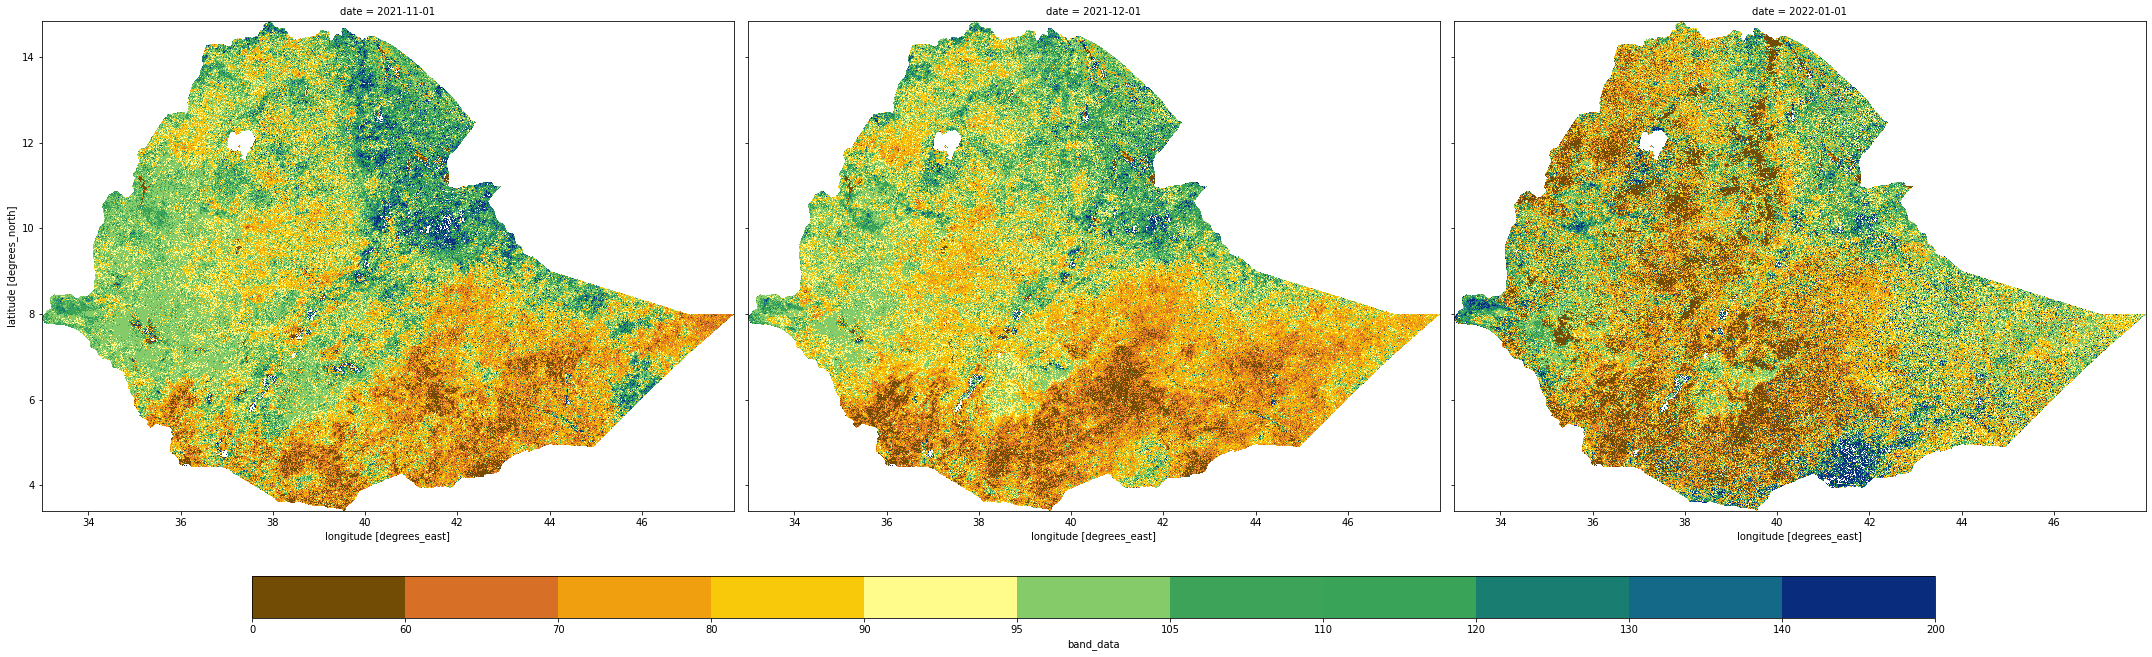

In [30]:
da.plot.imshow(
    col="date",
    levels=ndvi_bins,
    cmap=ListedColormap(ndvi_colors),
    figsize=(30,10),
    cbar_kwargs={
    "orientation": "horizontal",
    "shrink": 0.8,
    "aspect": 40,
    "pad": 0.1,
    'ticks': ndvi_bins,
    },
)

## Aggregation

Next we aggregate the data to the admin level. In general it is not recommended to aggregate to all these admins without a clear goal. But since requested we do an attempt. 

There are different methods of aggregation:
- min
- max
- mean
- median
- perc of area

Due to high fluctuations in the data, we estimate the min and max to not represent the situation accurately. 
The percentage of area brings an extra complexity as we then have to set a threshold. We therefore choose to not do that at this point. However, an option could be to set a threshold, e.g. <=100, and look at the perc of each adm being below that threshold. 

Based on the above we suggest to use the mean or median. Due to relatively high fluctuations, I suggest to use the median.

#### Adm3 vs Adm2
It was requested to aggregate the data to adm3. We quickly inspect how they look compared to the admin2's.We can see that there are more than 1000 admin3's. However, due to the high resolution of the data (what is the exact resolution?) and the large size of the country, we still expect it to be okay to aggregate to admin3 if needed.  

In [9]:
print(f"Number of adm3s: {len(gdf_adm3)}")
print(f"Number of adm2s: {len(gdf_adm2)}")

Number of adm3s: 1040
Number of adm2s: 92


<AxesSubplot:>

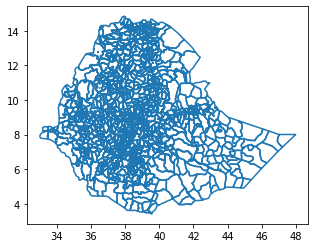

In [10]:
gdf_adm3.boundary.plot()

<AxesSubplot:>

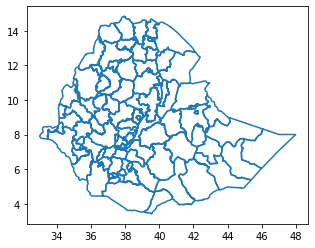

In [11]:
gdf_adm2.boundary.plot()

### Define functions

In [12]:
def aggregate_admin(da,gdf,pcode_col,bins=None):
    da_clip = da.rio.clip(gdf.geometry, drop=True, from_disk=True)
    df_stats=compute_raster_statistics(
        gdf=gdf,
        bound_col=pcode_col,
        raster_array=da_clip,
        lon_coord="x",
        lat_coord="y",
        stats_list=["min","median","mean","max","std","count"],
        #computes value where 20% of the area is above that value
        percentile_list=[80],
        all_touched=False,
    )
    #find better way to do this
    #dont understand why but df_stats_adm2.convert_dtypes() is not working
    df_stats[f"mean_{pcode_col}"]=df_stats[f"mean_{pcode_col}"].astype("float64")
    df_stats[f"median_{pcode_col}"]=df_stats[f"median_{pcode_col}"].astype("float64")
    if bins is not None: 
        df_stats["mean_binned"]=pd.cut(df_stats[f"mean_{pcode_col}"],bins)
        df_stats["median_binned"]=pd.cut(df_stats[f"median_{pcode_col}"],bins)
    gdf_stats=gdf[[pcode_col,"geometry"]].merge(df_stats,on=pcode_col)
    return gdf_stats

In [141]:
def plt_ndvi_dates(gdf_stats,data_col,colp_num=3,caption=None):
    num_plots = len(gdf_stats.date.unique())
    if num_plots==1:
        colp_num=1
    rows = math.ceil(num_plots / colp_num)
    position = range(1, num_plots + 1)
    fig=plt.figure(figsize=(30,10))
    for i,d in enumerate(gdf_stats.date.unique()):
        ax = fig.add_subplot(rows,colp_num,i+1)
        gdf_stats[gdf_stats.date==d].plot(ax=ax, column=data_col,
                             legend=True,#if i==num_plots-1 else False,
                            categorical=True,
                cmap=ListedColormap(ndvi_colors)
         )
        ax.set_title(f"{pd.to_datetime(str(d)).strftime('%d-%m-%Y')} till "
                     f"{(pd.to_datetime(str(d))+relativedelta(days=9)).strftime('%d-%m-%Y')}")
        ax.axis("off")
    if caption:
        plt.figtext(0.7, 0.2,caption)
    plt.suptitle("Percent of median NDVI",size=24,y=0.85)
    return fig


#### Aggregated to admin3
Below the values per admin3 are shown. We use the same bins as [those used by USGS/FewsNet](https://earlywarning.usgs.gov/fews/product/448). 
We can see the same pattern as we saw with the raw data, which is a good sign. The dissimilarity between the pattern beginning of December and beginning of January is even more clear from these plots. However, these plots should only be seen as the NDVI and not perse drought conditions as this e.g. depends on the rainy seasons. 

In [90]:
#this takes a couple of minutes to compute
gdf_stats_adm3=aggregate_admin(da,gdf_adm3,pcode3_col,bins=ndvi_bins)

In [100]:
gdf_stats_adm3["median_binned_str"]=pd.cut(gdf_stats_adm3[f"median_{pcode3_col}"],ndvi_bins,labels=ndvi_labels)

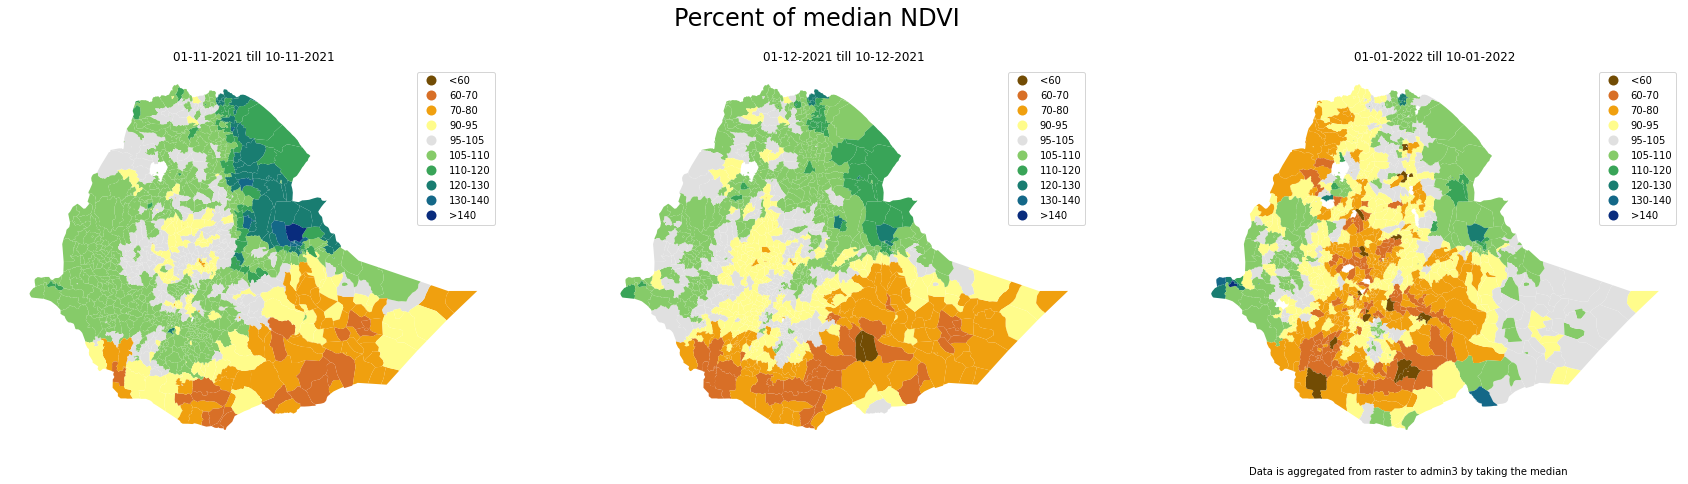

In [142]:
fig=plt_ndvi_dates(gdf_stats_adm3,"median_binned_str",caption="Data is aggregated from raster to admin3 by taking the median")
# fig.savefig(country_data_exploration_dir / "plots" / "eth_ndvi_adm3_20212022.png", facecolor="white", bbox_inches="tight")

To check, we do the same computations for the adm2 to see if the general patterns are the same. As we can see they indeed generally match though as expected the values at admin2 are more smoothed

In [16]:
gdf_stats_adm2=aggregate_admin(da,gdf_adm2,pcode2_col,bins=ndvi_bins)

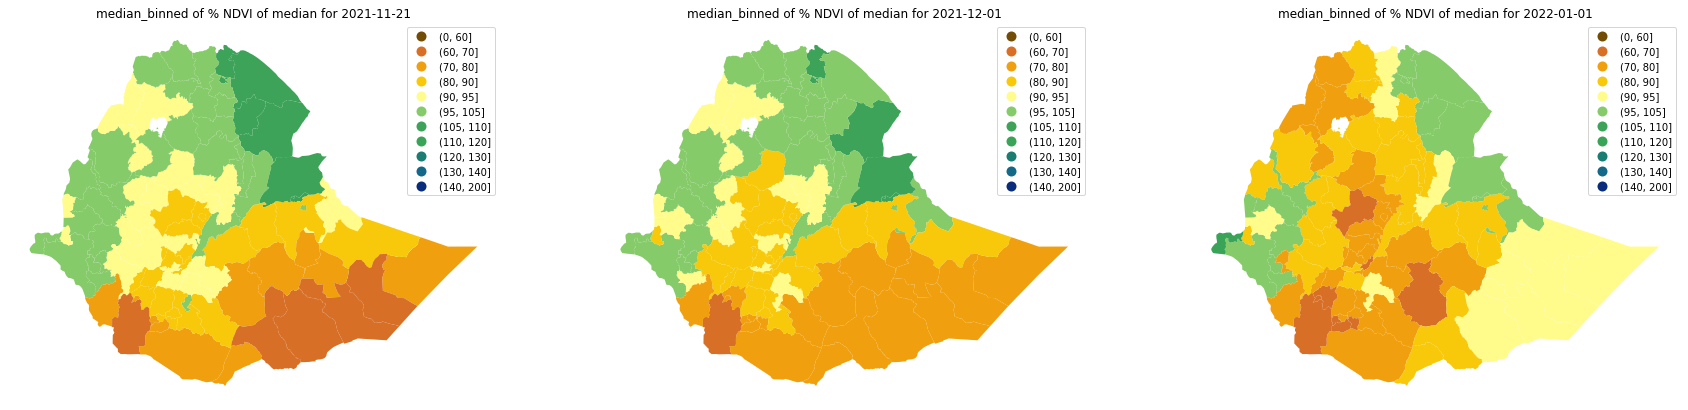

In [17]:
plt_ndvi_dates(gdf_stats_adm2,"median_binned")